# Copyright

Jelen iPython notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott 
"Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning 
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérjük az alábbi szerzőket értesíteni.

2017 (c) Szaszák György (szaszak kukac tmit pont bme pont hu)
         Moró Anna (moro kukac tmit pont bme pont hu)


A feladat írásjelek predikciója prozódiai információk alapján. A prozódiai egységek (ún. fonológiai frázis) típusát és hosszát, valamint a frázis utáni szünet hosszát készen kapjuk. Gyors, kicsi modellre van szükség a késleltetés kézben tartására és amiatt, hogy a háttérben működő beszédfelismerő elől az erőforrásokat nem vonjuk el. 

In [1]:
# Importok
from __future__ import print_function
import os
import numpy as np
from sklearn import preprocessing
np.random.seed(1337)

#import keras
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Dropout, LSTM, Activation, Bidirectional
from keras.models import Model,Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
import sys

import random

nb_features=3
logp="0" #sys.argv[1]
window=10 #int(sys.argv[2])


Using TensorFlow backend.


In [2]:
# 7-féle fonológiai (prozódiai) frázis van, ezeknek ismerjük a határait, a sorrendjét és a hosszát
pps=["sil","me","fe","fs","s","mv","fv"]
pp2int = dict((p, i) for i, p in enumerate(pps))
int2pp = dict((i, p) for i, p in enumerate(pps))

# 3-féle írásjelet modellezünk most
pms=["_",",","."]
pm2int = dict((p, i) for i, p in enumerate(pms))
int2pm = dict((i, p) for i, p in enumerate(pms))


In [3]:
# Segédfüggvények

def pad (data,window,label):
    padded=[]
    for i in range(window-1):
        padded.append(label)
    padded+=data
    padded.append(label)
    return padded

def preprocess_data(filename, nb_of_features, window):
    
    x1=[] # frázisszekvencia -> one-hot szekvencia
    x2=[] # frázishosszak (szekvencia)
    x3=[] # frázis végéig hátralévő idő (szekvencia)
    y0=[] # Írásjel-target szekvencia: minden frázis végére vonatkozik egy-egy címke

    with open(filename) as f:
        for line in f:
            data=line.split("\t")
            x1.append(data[1:-1])

            line=f.readline()
            data=line.split("\t")
            x2.append(data[1:-1])

            line=f.readline()
            data=line.split("\t")
            x3.append(data[1:-1])

            line=f.readline()
            data=line.split("\t")
            y0.append(data[1:-1])

            f.readline()
            
    samples1=[]
    samples2=[]
    samples3=[]
    targets=[]

    #Padding
    for i in range(len(x1)):
        s1=pad(x1[i],window,"sil")
        s2=pad(x2[i],window,"0")
        s3=pad(x3[i],window,"0")
        t0=pad(y0[i],window,"_")
        
        for j in range (len(x1[i])-window):
            samples1.append(s1[j:j+window])
            samples2.append(s2[j:j+window])
            samples3.append(s3[j:j+window])
            targets.append(t0[j+window-1])

    # Skálázás
    samples2=preprocessing.scale(samples2) # z norm
    samples3=preprocessing.scale(samples3)
    
    # Vektorizálás
    X = np.zeros((len(samples1), window, len(pps)+nb_of_features-1), dtype=np.float32)
    y = np.zeros((len(samples1), len(pms)), dtype=np.float32)
    
    for i in range(len(samples1)):
        for j in range(window):
            X[i, j, pp2int[samples1[i][j]]] = 1.0 # fráziscímke one-hot
            
            if ((nb_of_features == 2) or (nb_of_features == 3)):
                X[i, j, len(pps)]=samples2[i][j] # Z-normalizált hossz
                
            if (nb_of_features == 3):
                X[i, j, len(pps)+1]=samples3[i][j] # Z-normalizált hátralávő idő
                
            y[i, pm2int[targets[i]]] = 1.0

    print (filename, "Shape of x features: ", X.shape)
    print (filename, "Shape of y: ", y.shape)
    
    return X, y

# Az adatok kiegyensúlyozatlanok; nagyon sokszor nincs írásjel, ehhez képest ritka, amikor van, az írásjelből is vessző többször van, mint pont.
# Ez a függvény a hibafüggvényt egészíti ki, a hibák attól függően kerülnek súlyozásra, hogy mit rontottunk el
def get_class_weights(y, smooth_factor=0):

    counter={}
    for i in range(max(y)+1):
        counter[i]=0
    for i in y:
        counter[i]+=1

    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p

    majority = max(counter.values())

    return {cls: float(majority / count) for cls, count in counter.items()}


Az adatok a train.0 és test.0 fájlokban készen állnak a feldolgozásra.

In [5]:
# Adatok beolvasása

trainset="train."+logp
testset="test."+logp

x_data, y_data = preprocess_data(trainset, nb_features, window)
x_test, y_test = preprocess_data(testset, nb_features, window)

# Keverés
indices = np.arange(x_data.shape[0]) 
np.random.shuffle(indices)

data = x_data[indices]
target = y_data[indices]

# Validációs halmaz
train_data_end = int(len(data)*0.9)

x_train = data[:train_data_end]
y_train = target[:train_data_end]
x_validation = data[train_data_end:]
y_validation = target[train_data_end:]

print("X_tr: ", x_train.shape, "Y_tr: ", y_train.shape)
print("X_v: ", x_validation.shape, "Y_v: ", y_validation.shape)

# Adatok kiegyensúlyozása
y_classes=np.argmax(y_test,axis=1)
class_weights=get_class_weights(y_classes,0.8)

train.0 Shape of x features:  (10289, 10, 9)
train.0 Shape of y:  (10289, 3)
test.0 Shape of x features:  (1566, 10, 9)
test.0 Shape of y:  (1566, 3)
X_tr:  (9260, 10, 9) Y_tr:  (9260, 3)
X_v:  (1029, 10, 9) Y_v:  (1029, 3)


In [6]:
# Modell
model = Sequential()

earlyStopping=EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
modelCheckpoint=ModelCheckpoint('punctuation_model.h5py', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

model.add(Bidirectional(LSTM(20,return_sequences=True), 
                        input_shape=(x_data.shape[1], x_data.shape[2])))
model.add(Dropout(0.25))
    
model.add(Bidirectional(LSTM(20,return_sequences=False)))
model.add(Dropout(0.3))


model.add(Dense(units=y_data.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [7]:
# Tanítás

model.fit(x_train, y_train, callbacks=[earlyStopping,modelCheckpoint], 
          validation_data=(x_validation, y_validation), epochs=5, batch_size=80, class_weight=class_weights)


Train on 9260 samples, validate on 1029 samples
Epoch 1/5
9260/9260 [==============================] - 5s 509us/step - loss: 1.0798 - acc: 0.7336 - val_loss: 0.6236 - val_acc: 0.7911
Epoch 2/5
9260/9260 [==============================] - 4s 384us/step - loss: 0.7859 - acc: 0.8244 - val_loss: 0.4930 - val_acc: 0.8260
Epoch 3/5
9260/9260 [==============================] - 4s 409us/step - loss: 0.7039 - acc: 0.8405 - val_loss: 0.4889 - val_acc: 0.8328
Epoch 4/5
9260/9260 [==============================] - 4s 409us/step - loss: 0.6714 - acc: 0.8474 - val_loss: 0.4762 - val_acc: 0.8328
Epoch 5/5
9260/9260 [==============================] - 4s 459us/step - loss: 0.6522 - acc: 0.8491 - val_loss: 0.4599 - val_acc: 0.8397


In [8]:
# Tesztelés accuracy-ra, overall
scores=model.evaluate(x_test, y_test)
print (scores)

1566/1566 [==============================] - 0s 169us/step
[0.3561590664840445, 0.88314176275660095]


1566/1566 [==============================] - 0s 231us/step


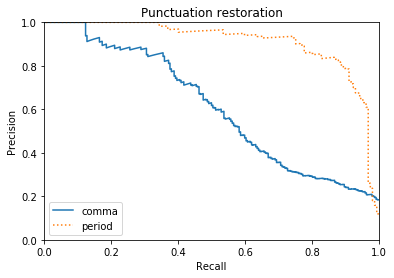

In [9]:
# Tesztelés percision/recall, írásjelekre külön
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_curve
from sklearn import metrics

p=model.predict_proba(x_test) # to predict probability
proba_comma=p[:,pm2int[',']]
true_comma=y_test[:,pm2int[',']]
prc_c, rec_c, thr_c = precision_recall_curve(true_comma, proba_comma)

proba_period=p[:,pm2int['.']]
true_period=y_test[:,pm2int['.']]
prc_p, rec_p, thr_p = precision_recall_curve(true_period, proba_period)

import matplotlib.pyplot as plt
#from scipy.interpolate import interp1d

plt.plot(rec_c, prc_c, '-', label='comma')
plt.plot(rec_p, prc_p, ':', label='period')
plt.legend(loc='lower left')
plt.axis([0,1,0,1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Punctuation restoration')
plt.show()


In [13]:
# AUC
auc_c=metrics.auc(prc_c,rec_c,reorder=True)
auc_p=metrics.auc(prc_p,rec_p,reorder=True)
print ("Area under PR curves: ", auc_c, auc_p)


Area under PR curves:  0.439216735616 0.796700216123


1566/1566 [==============================] - 0s 130us/step
             precision    recall  f1-score   support

 class 0(-)     0.9039    0.9914    0.9456      1167
 class 1(,)     0.8542    0.3388    0.4852       242
 class 2(.)     0.7579    0.9172    0.8300       157

avg / total     0.8816    0.8831    0.8629      1566

Confusion matrix, without normalization
[[1157    6    4]
 [ 118   82   42]
 [   5    8  144]]


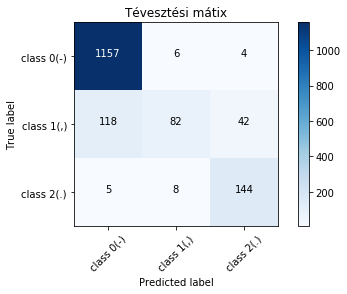

In [10]:
# Táblázatosan, ill. tévesztési mátrix
y_pred=list(model.predict_classes(x_test))
y_ref=list(np.argmax(y_test,axis=1))
target_names = ['class 0(-)', 'class 1(,)', 'class 2(.)']
print(classification_report(y_ref, y_pred,target_names=target_names,digits=4))
cfm=confusion_matrix(y_ref, y_pred)

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure()
plot_confusion_matrix(cfm, classes=target_names,
                      title='Tévesztési mátix')
plt.show()